#Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn import preprocessing
from math import sqrt

#Task 1: Acquire the data

## Load and process Fashion MNIST

Load and process the dataset

In [2]:
# Define the transformations to apply to the data (normalization with mean and std of 0.5)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,),)])

# Download and load the training data
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:01<00:00, 16804121.03it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 267790.26it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5084537.45it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6474445.87it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Vectorize datasets to obtain arrays of length 60000 (number of elements in the trainset) and 10000 (number of elements in testset). Each element in both arrays will be a vector of length $28*28=784$.

In [3]:
#Normalized data, with the min/max along each dimension equal to -1 and 1 respectively, which is being done by the transform function
#Now we just use the dataloader to take out the set which is normalized
trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False)

for (images, labels) in trainloader:
  fashion_trainset_x = images.numpy().reshape(len(trainset), (images.shape[2]*images.shape[3]), images.shape[1])
  fashion_trainset_y = labels.numpy()

for (images, labels) in testloader:
  fashion_testset_x = images.numpy().reshape(len(testset), (images.shape[2]*images.shape[3]), images.shape[1])
  fashion_testset_y = labels.numpy()

#Now the datasets are conerted into numpy arrays


Visualize the data

In [4]:
# Preparing for validation set
indices = list(range(len(trainset)))
np.random.shuffle(indices)
# to get 20% of the train set
delim = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indices[:delim])
valid_sample = SubsetRandomSampler(indices[delim:])

# data loader
trainloader = DataLoader(trainset, sampler=train_sample, batch_size=64)
validloader = DataLoader(trainset, sampler=valid_sample, batch_size=64)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

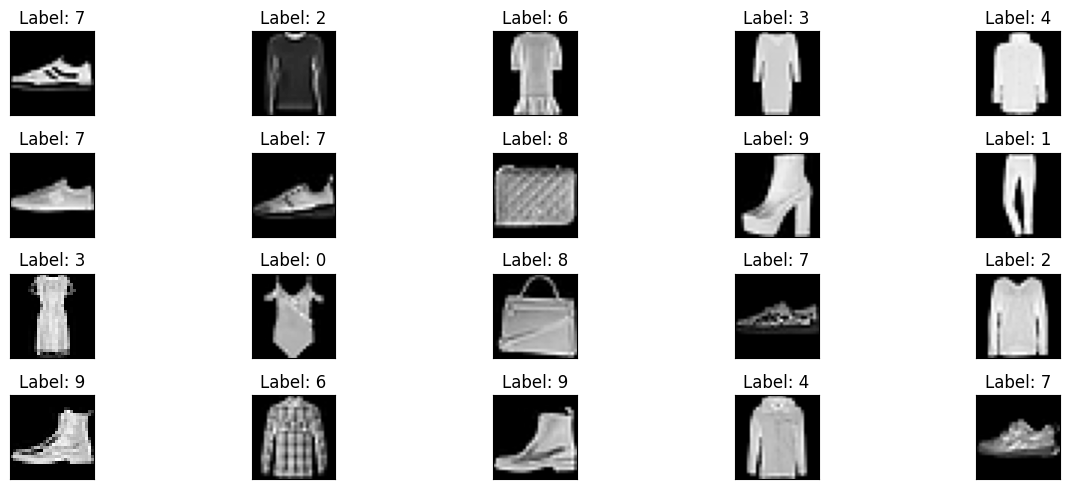

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

fig = plt.figure(figsize=(15,5))
for idx in np.arange(20):
  ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]),cmap='gray')
  ax.set_title("Label: " + str(labels[idx].item()))
  fig.tight_layout()

Visualize the distribution of pixel values across all datapoints

<ipython-input-6-94897b1951c0>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,1,2)


Text(0.5, 1.0, 'Pixel Value Distribution')

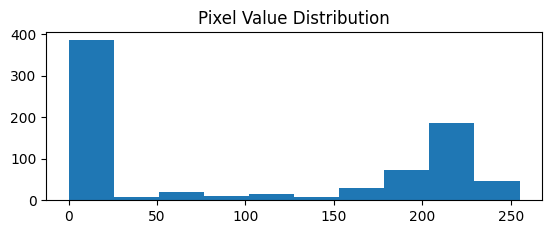

In [6]:
fig = plt.figure()
plt.imshow(trainset.data[0], cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])
plt.subplot(2,1,2)
plt.hist(trainset.data[0].reshape(784))
plt.title("Pixel Value Distribution")

Visualize the distribution of pixel values across all datapoints

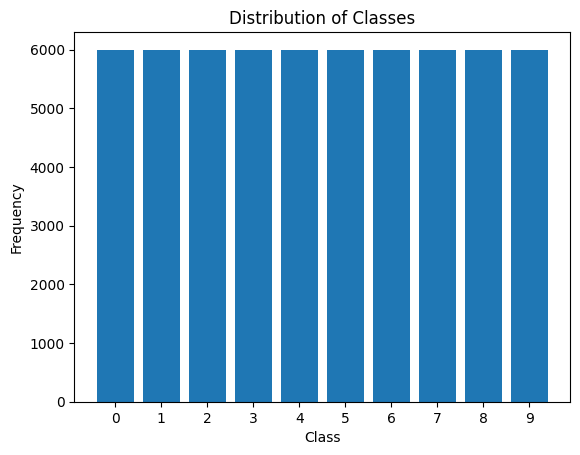

In [7]:
unique_targets, occurrences = np.unique(trainset.targets, return_counts=True)

# Create a bar plot
plt.bar(unique_targets, occurrences, align='center')
plt.xticks(unique_targets)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Distribution of Classes')

# Show plot
plt.show()

## Load and process Cifar-10 for Displaying


In [8]:
# Define the transformation to flatten the images and concatenate RGB values
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-10 dataset with flattened RGB vectors
class CIFAR10FlattenRGB(torchvision.datasets.CIFAR10):
    def __getitem__(self, index):
        img, target = super(CIFAR10FlattenRGB, self).__getitem__(index)
        img = img.view(-1)  # Flatten the image into a 1D tensor
        return img, target

train_dataset = CIFAR10FlattenRGB(root='./data', train=True, transform=transform, download=True)
test_dataset = CIFAR10FlattenRGB(root='./data', train=False, transform=transform, download=True)

100%|██████████| 170498071/170498071 [00:01<00:00, 91706072.19it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Visualize sample images

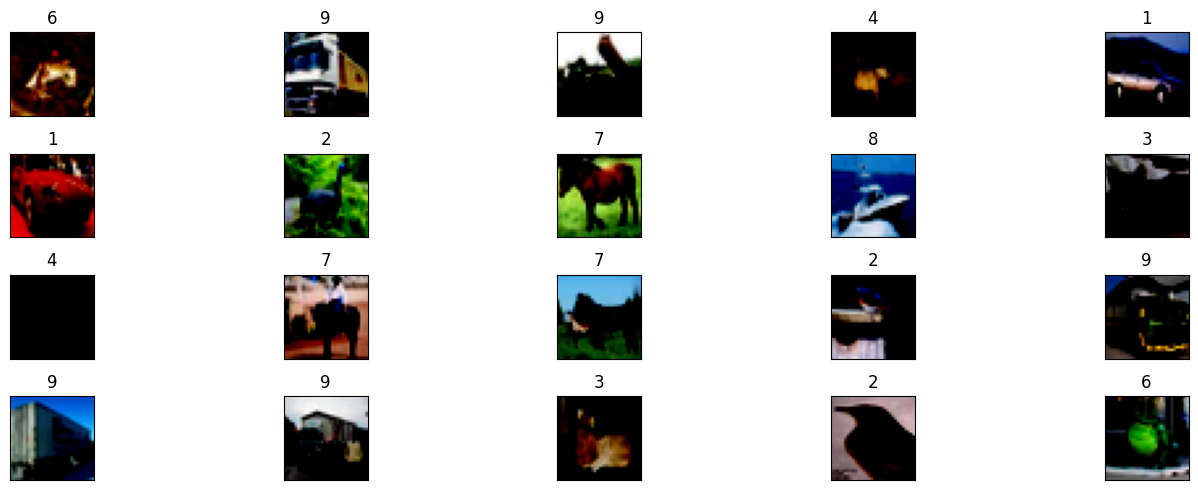

In [9]:
# Create a data loader for visualization without shuffling
batch_size = 64
#print(train_dataset)
visualization_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

fig = plt.figure(figsize=(15, 5))  # Increase the figure size
number_pics_iterate_over = 20

# Calculate the grid size based on the number of images to visualize
num_rows = (number_pics_iterate_over + 4) // 5

ind = 0
for idx, (images, labels) in enumerate(visualization_loader):
  if idx * batch_size >= number_pics_iterate_over:
    break

  for i in range(batch_size):
    if idx * batch_size + i >= number_pics_iterate_over:
      break

    ax = fig.add_subplot(num_rows, 5, idx * batch_size + i + 1, xticks=[], yticks=[])
    # Reshape the flattened image back to (3, 32, 32) for display
    img = images[i].reshape(3, 32, 32).permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)                                                ## Added this line
    ax.imshow(img)

    ax.set_title(labels[i].item())
    ind = idx

fig.tight_layout()
plt.show()

# Get the last image and its label
last_index = len(train_dataset) - 1
last_image, last_label = train_dataset[last_index]

Plot the class distribution of the CIFAR dataset

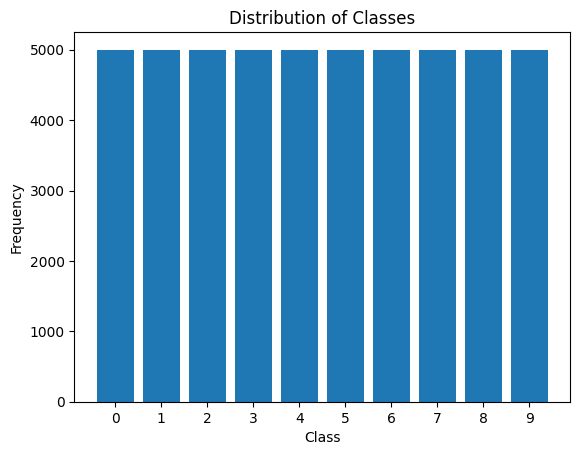

In [10]:
unique_targets, occurrences = np.unique(train_dataset.targets, return_counts=True)

# Create a bar plot
plt.bar(unique_targets, occurrences, align='center')
plt.xticks(unique_targets)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Distribution of Classes')

# Show plot
plt.show()

#Task 2: Implement a Multilayer Perceptron

### Defining Helper Classes for the Activation Functions

In [11]:
############################### Defining Activation Function Classes and their methods! ##########################################
class Relu_Class:
  def activation(z):
    return np.maximum(0,z)
  def prime(z):
      z[z<=0] = 0
      z[z>0] = 1
      return z

class Leaky_Relu_Class:
  @staticmethod
  def activation(z):
    alpha = 0.1
    return np.where(z<=0,alpha*z,z)
  def prime(z):
    alpha = 0.1
    return np.where(z<=0,alpha,1)

class Sigmoid_Class:
  @staticmethod
  def activation(z):
      return 1 / (1 + np.exp(-z))
  def prime(z):
      return Sigmoid_Class.activation(z) * (1 - Sigmoid_Class.activation(z))

class tanh_Class:
  @staticmethod
  def activation(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
  def prime(z):
    return 1 - np.power(tanh_Class.activation(z), 2)

class softmax_Class:
  @staticmethod
  def activation(x):
    e = np.exp(x-np.max(x))
    s = np.sum(e, axis=1, keepdims=True)
    return e/s
  @staticmethod
  def prime(z):
      return softmax_Class.activation(z)*softmax_Class.activation(1-z)

############################### Defining the Softmax Loss (Cross_Entropy) Class and its related methods #######################################################
class Cross_Entropy:
  def __init__(self, activation_fn):
      self.activation_fn = activation_fn

  def activation(self, z):
    return self.activation_fn.activation(z)

  def loss(y_true, y_pred):
      epsilon=1e-12
      y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
      N = y_pred.shape[0]
      loss = -np.sum(y_true*np.log(y_pred+1e-9))/N
      return loss

  @staticmethod
  def prime(Y, AL):
      return AL - Y

  def delta(self, y_true, y_pred):
      return self.prime(y_true, y_pred) * self.activation_fn.prime(y_pred)

### Defining the MLP Class

In [12]:
class MultiLayerPerceptron:
  #Constructor
  def __init__(self, dimensions, activations, weight = "uniform"):
    """
    list of dimensions (input, hidden layer(s), output)
    list of activation functions (relu, softmax etc) (in the case of 1 hidden layer)
    """
    self.num_layers = len(dimensions) #Tells us the number of layers in the MLP model
    self.loss = None      #init
    self.alpha = None   #init
    # Weights, biases and the activations will be initialized as dictionaries, with the key being the index and the value being the subsequent Matrix
    self.w = dict()
    self.b = dict()
    self.activations = dict()
    self.lambd = None
    # initial values for the weights as well as the biases according to the number of layers we have in the model
    for i in range(self.num_layers - 1):
      # Starting from index i=1, we initialize weights according to the weight parameter
      if weight == "zeros":
        self.w[i + 1] = np.zeros((dimensions[i],dimensions[i+1]))
      elif weight == "uniform":
        self.w[i+1] = np.random.uniform(-1,1, (dimensions[i], dimensions[i+1]))
      elif weight == "gaussian":
        self.w[i+1] = np.random.normal(0,1, (dimensions[i], dimensions[i+1]))
      elif weight == "xavier":
        std_dev = sqrt(2/(dimensions[i] + dimensions[i+1]))
        self.w[i+1] = np.random.normal(0,std_dev, (dimensions[i], dimensions[i+1]))
      elif weight == "kaiming":
        self.w[i+1] = np.random.normal(0,2/(dimensions[i]), (dimensions[i], dimensions[i+1]))
      else:
        self.w[i + 1] = np.random.randn(dimensions[i], dimensions[i + 1]) / np.sqrt(dimensions[i])  #Weight matrix set to the |i| X |i+1|

      #Now we init the biases to 0's according to the appropriate dimension
      self.b[i + 1] = np.zeros(dimensions[i + 1])

      #Now we init the activations (starting from 2, since 1 will have the x as input)
      self.activations[i + 2] = activations[i]

  def forward_pass(self, x):
    """
    Allows us to give an input, and go through the whole network till we reach the outputs
    Returns a tuple containing the z's and the activations applied onto the z's according to each activation function we've provided
    """
    z = dict()  #Creating a dictionary for the z's
    a = dict()  #Creating a dictionary for the a's      ##Note, these dictionaries are for a single forward prop instance

    a[1] = x    #Setting as the first activation, the x's since that is what we will use

    for i in range(1,self.num_layers):      #Starting from 1, as all the dictionaries are indexed by 1
      #Calculating the z's and the a's
      z[i+1] = np.dot(a[i], self.w[i]) + self.b[i]     #Applying the weights to the x's/prev activation to get the next set of values
      a[i+1] = self.activations[i+1].activation(z[i+1])   #We apply the next activation function on the z we just calculated and put it in the next activation layer to be
                                                          # calculated in the next iteration for z

    return (z, a)   #Returning the tuple of z's and a's (to be used in the back prop / for prediction)

  def updater(self, i, dw, delta):
    """
    updates the weights/biases according to the index (i), the partial derivative and the error, uses L2 regularization if lambd set to non-zero, else its not regularized
    """
    reg_matrix_w = np.zeros_like(self.w[i])

    if self.regg == 1:
      dw += (self.lambd) * np.sign(self.w[i])
      pass
    elif self.regg == 2:
      dw += 2 * (self.lambd) * self.w[i]

    #If self.regg == 0, then we're not going to be using regularization and hence dw will not be updated
    self.w[i] = self.w[i] - self.alpha * dw
    self.b[i] = self.b[i] - self.alpha * np.mean(delta, 0)

    #The above will be done for each iteration in the gradient descent

  def back_pass(self, z, a, y):
    """
    Compute the partial derivatives and the error for the final layer, does backpropogation, by propogating the gradients back through the network
    """
    delta = self.loss.delta(y, a[self.num_layers])
    dw = np.dot(a[self.num_layers - 1].T, delta)

    derivatives = dict()  #Creating a dictionary for the delta and the derivatives
    derivatives[self.num_layers - 1] = (dw, delta) #Putting the stuff computed above in the dictionary

    #Now we have the back propogation loop!!                        ####################################################################### Very Important!!!!!
    for i in reversed(range(2, self.num_layers)):
      delta = np.dot(delta, self.w[i].T) * self.activations[i].prime(z[i])
      dw = np.dot(a[i - 1].T, delta)
      derivatives[i - 1] = (dw, delta)

    for key, value in derivatives.items():
      self.updater(key, value[0], value[1])       #value[0] contains dw, while value[1] contains delta, we're unpacking the tuple we packed and added to the derivatives dictionary

    ############################        Completed Back Propogation!!!


  def fit(self, x_train, y_train, epochs, mini_batch_size, alpha, x_test, y_test, regularization = 0, lambd = 0):
    """
    main function used to fit the model using the training data, and then used to test using the evac function
    """
    #Converting one_hot encoding for y_train and y_test
    y_train = np.eye(10)[y_train]
    y_test = np.eye(10)[y_test]

    #Flattening the data for the x:
    n_features= x_train.shape[1]*x_train.shape[2]
    x_train = x_train.reshape(-1, n_features)
    x_test = x_test.reshape(-1, n_features)
    #Reshapes both x_train and x_test from a 3D Matrix to a 2D Matrix

    #Setting up some variables which we skipped over in the initialization which are needed
    self.alpha = alpha
    self.loss = Cross_Entropy(self.activations[self.num_layers])
    # self.lambd = regularization() Need to fix this!!!!!!!             ######## FIX THIS
    if regularization == 0:
      print("No Reg")
      self.regg = 0
      self.lambd = 0
    elif regularization == 1:      ##Doing L1 Regularization
      print("L1 Reg")
      self.regg = 1
      self.lambd = lambd

    else: #Do L2 Regularization       #Regularization = 2,3 4 etc anything
      print("L2 Reg")
      self.regg = 2
      self.lambd = lambd


    #Setting up some miscelaneous parameters for graphing!
    self.train_logger = []
    self.test_logger = []
    self.cost_logger = []

    ##Starting the SGD!!!

    for i in range(epochs):
      #Randomizing the data:
      permutation = np.random.permutation(x_train.shape[0])
      x_S = x_train[permutation]
      y_S = y_train[permutation]

      #Setting up the mini_batches
      num_mini_batches = x_train.shape[0] // mini_batch_size

      for j in range(num_mini_batches):
        start_i = j*mini_batch_size
        end_i = (j+1)*mini_batch_size

        #Given the indices, now we do a forward pass on them, and then a backward pass
        (z_dict, a_dict) = self.forward_pass(x_S[start_i:end_i])

        #Now using the values in z_dict and a_dict, we do a backward pass to propogate the gradients back to the layers
        self.back_pass(z_dict, a_dict, y_S[start_i:end_i])
        #Done training now

      #Now we check the training and testing accuracy and run the evaluate_acc function
      training_acc = self.evaluate_acc(self.predict(x_train), np.argmax(y_train,axis = 1))
      testing_acc = self.evaluate_acc(self.predict(x_test), np.argmax(y_test,axis = 1))

      #training_acc = np.mean(self.predict(x_train) == np.argmax(y_train,axis = 1))
      #testing_acc = np.mean(self.predict(x_test) == np.argmax(y_test,axis = 1))

      #Logging the accuracies
      self.train_logger.append(training_acc)
      self.test_logger.append(testing_acc)

      # print results for monitoring while training
      print("Epoch {0} train data: {1} %".format(i, 100 * (training_acc)))
      print("Epoch {0} test data: {1} %".format(i, 100 * (testing_acc)))

  def predict(self, x):
    """
    Feeds forward the x to get the output, and returns the argmax
    """
    (garbage, a) = self.forward_pass(x)
    return np.argmax(a[self.num_layers], axis = 1)

  def evaluate_acc(self, yhat, y):  ##Used for evaluating the accuracy, given true y's and predicted y's
    return np.mean(yhat == y)


In [13]:
# Running the Model
# print(fashion_trainset_x.shape, fashion_trainset_y.shape)
# print(fashion_testset_x.shape, fashion_testset_y.shape)
# net = MultiLayerPerceptron([784,64,64,10],[Relu_Class, Relu_Class, softmax_Class], weight = "kaiming")
# net.fit(fashion_trainset_x, fashion_trainset_y, 100, 256, 0.001, fashion_testset_x, fashion_testset_y, regularization = 0, lambd = 0.05)   ##Need to add regularization at the end

#For Regularization:
# '''
# No: regularization = 0, L1: regularization = 1, L2: regularization = 2
# For L1, L2 u assign lambd as the regularization strength
# Pre test, L1: keep lambd = 0.0005 (Very Weak, Accuracy) -> it implies that the higher most of our features are useful, and we loose information if we force them to go to 0
# L2: lambd = 0.01 (Stronger, If stronger needed, must increase the batch size or the learning rate to kill randomization/noise resulting from L2)

# Note: It may appear as if accuracy goes down in epochs, but it will pull up eventually, as the neurons get used to the regularization and start making good predictions
# For a batch size of 256, can increase the epochs to 500, approx compute time will be 20 mins per fit for MNIST
# '''

#Task 3: Run the experiments and report

Define a helper function `plot_graph` which takes in a list of tuples $data$ and prints a graph displaying that data.

## Helper Functions & Hyper Parameters

In [ ]:
#########################       CONSTANT FOR NUM OF EPOCHS!!! ##################
MLP_EPOCHS = 300
CNN_EPOCHS = 100

In [ ]:
#Setting batch_size
perm_batch_size = 256

In [ ]:
def compute_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

In [ ]:
def plot_graph(title, data=None, x_label="Epochs", y_label="Accuracy"):
    if data is None:
        raise ValueError("Data should not be None.")

    for series_name, y in data:
        x = [f'{xx}' for xx in np.arange((len(y)))]
        plt.plot(np.asarray(x, float), y, label=series_name)

    # Setting labels, title, and x-axis ticks
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def plot_graph_CNN(title, data=None, x_label="Epochs", y_label="Accuracy"):
    if data is None:
        raise ValueError("Data should not be None.")

    for series_name, y_values in data:
        x_values = list(range(len(y_values)))
        plt.plot(x_values, y_values, label=series_name)

    # Setting labels, title, and x-axis ticks
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    max_length = max(len(y_values) for _, y_values in data)
    plt.xticks(list(range(0, max_length, 10)))  # Adjusted for varying lengths and sets ticks for every 10 numbers

    plt.legend()
    plt.grid(True)
    plt.show()

##Part 1: Varying weight initialization
Experiment with initializing model weights in a few different ways. Create several MLPs with a single hidden layer having 128 units, initializing the weights as (1) all zeros (2) Uniform [-1, 1] (3) Gaussian N(0,1) (4) Xavier (5) Kaiming.

After training these models, compare the effect of weight initialization on the training curves and test accuracy on the Fashion MNIST dataset.

In [ ]:
# create models with each type of weight initialization
MLP_zeros = MultiLayerPerceptron([784, 128, 10], [Relu_Class, softmax_Class], weight = "zeros")
MLP_uniform = MultiLayerPerceptron([784, 128, 10], [Relu_Class, softmax_Class], weight = "uniform")
MLP_gaussian = MultiLayerPerceptron([784, 128, 10], [Relu_Class, softmax_Class], weight = "gaussian")
MLP_xavier = MultiLayerPerceptron([784, 128, 10], [Relu_Class, softmax_Class], weight = "xavier")
MLP_kaiming = MultiLayerPerceptron([784, 128, 10], [Relu_Class, softmax_Class], weight = "kaiming")

Train all of the models:

In [ ]:
MLP_zeros.fit(fashion_trainset_x, fashion_trainset_y, 300, 256, 0.001, fashion_testset_x, fashion_testset_y, regularization = 0, lambd = 0)
MLP_uniform.fit(fashion_trainset_x, fashion_trainset_y, 300, 256, 0.001, fashion_testset_x, fashion_testset_y, regularization = 0, lambd = 0)
MLP_gaussian.fit(fashion_trainset_x, fashion_trainset_y, 300, 256, 0.001, fashion_testset_x, fashion_testset_y, regularization = 0, lambd = 0)
MLP_xavier.fit(fashion_trainset_x, fashion_trainset_y, 300, 256, 0.001, fashion_testset_x, fashion_testset_y, regularization = 0, lambd = 0)
MLP_kaiming.fit(fashion_trainset_x, fashion_trainset_y, 300, 256, 0.001, fashion_testset_x, fashion_testset_y, regularization = 0, lambd = 0)

No Reg
Epoch 0 train data: 10.0 %
Epoch 0 test data: 10.0 %
Epoch 1 train data: 10.0 %
Epoch 1 test data: 10.0 %
Epoch 2 train data: 10.0 %
Epoch 2 test data: 10.0 %
Epoch 3 train data: 10.0 %
Epoch 3 test data: 10.0 %
Epoch 4 train data: 10.0 %
Epoch 4 test data: 10.0 %
Epoch 5 train data: 10.0 %
Epoch 5 test data: 10.0 %
Epoch 6 train data: 10.0 %
Epoch 6 test data: 10.0 %
Epoch 7 train data: 10.0 %
Epoch 7 test data: 10.0 %
Epoch 8 train data: 10.0 %
Epoch 8 test data: 10.0 %
Epoch 9 train data: 10.0 %
Epoch 9 test data: 10.0 %
Epoch 10 train data: 10.0 %
Epoch 10 test data: 10.0 %
Epoch 11 train data: 10.0 %
Epoch 11 test data: 10.0 %
Epoch 12 train data: 10.0 %
Epoch 12 test data: 10.0 %
Epoch 13 train data: 10.0 %
Epoch 13 test data: 10.0 %
Epoch 14 train data: 10.0 %
Epoch 14 test data: 10.0 %
Epoch 15 train data: 10.0 %
Epoch 15 test data: 10.0 %
Epoch 16 train data: 10.0 %
Epoch 16 test data: 10.0 %
Epoch 17 train data: 10.0 %
Epoch 17 test data: 10.0 %
Epoch 18 train data: 10

See results of weight initialized to 0

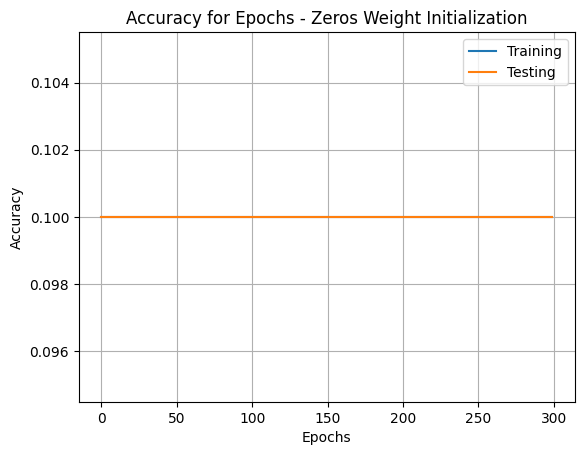

In [ ]:
data = [("Training", MLP_zeros.train_logger),("Testing", MLP_zeros.test_logger)]
plot_graph("Accuracy for Epochs - Zeros Weight Initialization", data)

See results of weight initialized to uniform distribution

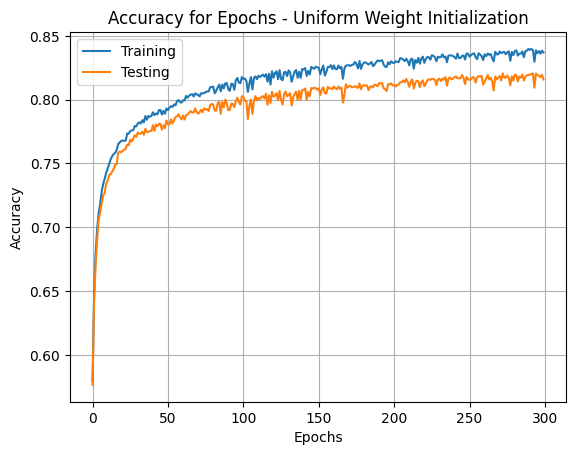

In [ ]:
data = [("Training", MLP_uniform.train_logger),("Testing", MLP_uniform.test_logger)]
plot_graph("Accuracy for Epochs - Uniform Weight Initialization", data)

See results of weight initialized to gaussian distribution

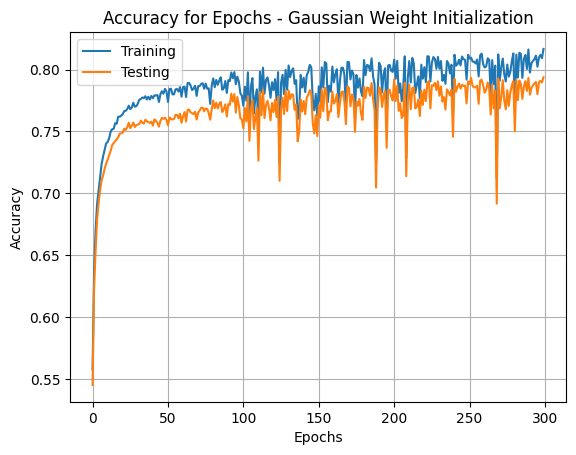

In [ ]:
data = [("Training", MLP_gaussian.train_logger),("Testing", MLP_gaussian.test_logger)]
plot_graph("Accuracy for Epochs - Gaussian Weight Initialization", data)

See results of weight initialized to xavier distribution

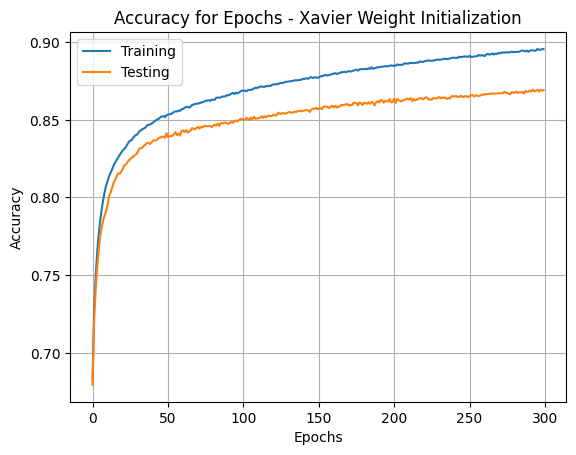

In [ ]:
data = [("Training", MLP_xavier.train_logger),("Testing", MLP_xavier.test_logger)]
plot_graph("Accuracy for Epochs - Xavier Weight Initialization", data)

See results of weight initialized to kaiming distribution

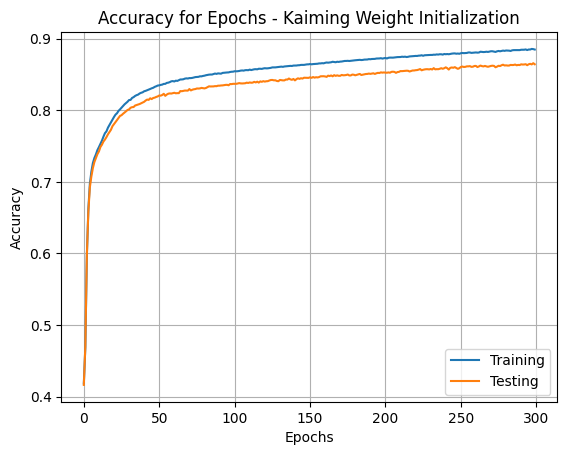

In [ ]:
data = [("Training", MLP_kaiming.train_logger),("Testing", MLP_kaiming.test_logger)]
plot_graph("Accuracy for Epochs - Kaiming Weight Initialization", data)

## Part 2: Varying layers
 Create three different models: (1) an MLP with no hidden layers, (2) an MLP with a single hidden layer having 128 units and ReLU activations, (3) an MLP with 2 hidden layers each having 128 units with ReLU activations. It should be noted that since we want to perform classification, all of these models should have a softmax layer at the end.

 After training, compare the test accuracy of these three models on the Fashion MNIST dataset. Comment on how non-linearity and network depth affects the accuracy. Are the results that you obtain expected?

Define 3 models:
  - `MLP_0` with no hidden layers
  - `MLP_1` with 1 hidden layer with 128 neurons
  - `MLP_3` with 2 hidden layers, each with 128 neurons.

In [ ]:
MLP_0 = MultiLayerPerceptron([784, 10], [softmax_Class], weight = "kaiming")
MLP_1 = MultiLayerPerceptron([784, 128, 10], [Relu_Class, softmax_Class], weight = "kaiming")
MLP_2 = MultiLayerPerceptron([784, 128, 128, 10], [Relu_Class, Relu_Class, softmax_Class], weight = "kaiming")

Train each model:

In [ ]:
MLP_0.fit(fashion_trainset_x, fashion_trainset_y, 300, 256, 0.001, fashion_testset_x, fashion_testset_y, regularization = 0, lambd = 0)
MLP_1.fit(fashion_trainset_x, fashion_trainset_y, 300, 256, 0.001, fashion_testset_x, fashion_testset_y, regularization = 0, lambd = 0)
MLP_2.fit(fashion_trainset_x, fashion_trainset_y, 300, 256, 0.001, fashion_testset_x, fashion_testset_y, regularization = 0, lambd = 0)

No Reg
Epoch 0 train data: 72.975 %
Epoch 0 test data: 72.22 %
Epoch 1 train data: 75.24 %
Epoch 1 test data: 74.57000000000001 %
Epoch 2 train data: 76.64666666666666 %
Epoch 2 test data: 75.76 %
Epoch 3 train data: 77.79 %
Epoch 3 test data: 76.73 %
Epoch 4 train data: 78.57 %
Epoch 4 test data: 77.53999999999999 %
Epoch 5 train data: 79.13166666666666 %
Epoch 5 test data: 78.07 %
Epoch 6 train data: 79.56166666666667 %
Epoch 6 test data: 78.68 %
Epoch 7 train data: 80.02333333333334 %
Epoch 7 test data: 79.13 %
Epoch 8 train data: 80.35333333333334 %
Epoch 8 test data: 79.41 %
Epoch 9 train data: 80.66333333333333 %
Epoch 9 test data: 79.75999999999999 %
Epoch 10 train data: 80.875 %
Epoch 10 test data: 80.01 %
Epoch 11 train data: 81.145 %
Epoch 11 test data: 80.19 %
Epoch 12 train data: 81.36833333333333 %
Epoch 12 test data: 80.36 %
Epoch 13 train data: 81.53666666666666 %
Epoch 13 test data: 80.35 %
Epoch 14 train data: 81.70333333333333 %
Epoch 14 test data: 80.62 %
Epoch 15 tr

See results of `MLP_0`

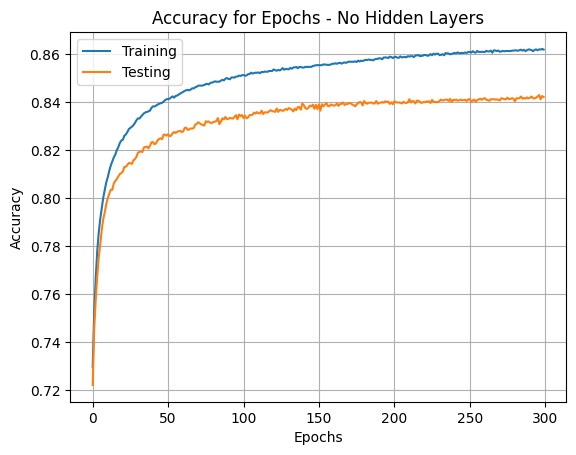

In [ ]:
data = [("Training", MLP_0.train_logger),("Testing", MLP_0.test_logger)]
plot_graph("Accuracy for Epochs - No Hidden Layers", data)

See results of `MLP_1`

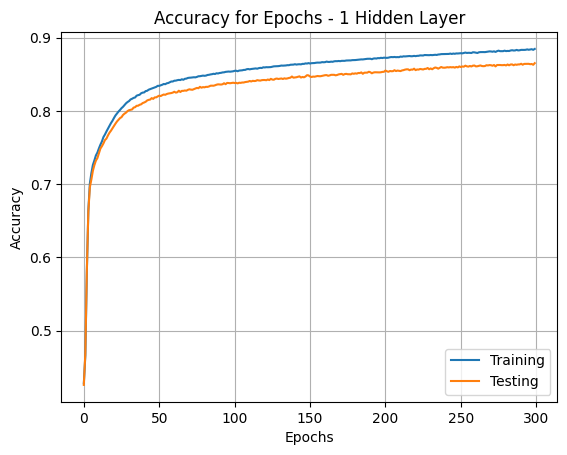

In [ ]:
data = [("Training", MLP_1.train_logger),("Testing", MLP_1.test_logger)]
plot_graph("Accuracy for Epochs - 1 Hidden Layer", data)

See results of `MLP_2`

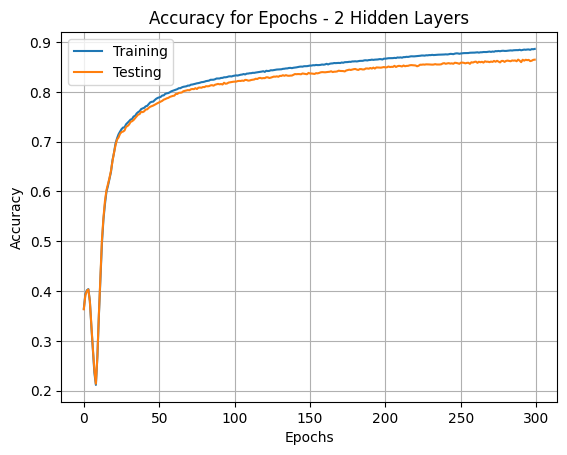

In [ ]:
data = [("Training", MLP_2.train_logger),("Testing", MLP_2.test_logger)]
plot_graph("Accuracy for Epochs - 2 Hidden Layers", data)

## Part 3: Varying activation functions
Take the last model above, the one with 2 hidden layers, and create two different copies of it in which you pick two activations of your choice (except ReLU) from the course slides. After training these two models on Fashion MNIST compare their test accuracies with the model with ReLU activations.

Comment on the performances of these models: which one is better and why? Are certain activations better than others? If the results are not as you expected, what could be the reason?

In [ ]:
MLP_sigmoid = MultiLayerPerceptron([784, 128, 128, 10], [Sigmoid_Class, Sigmoid_Class, softmax_Class], weight = "kaiming")

MLP_leaky_ReLU = MultiLayerPerceptron([784, 128, 128, 10], [Leaky_Relu_Class, Leaky_Relu_Class, softmax_Class], weight = "kaiming")

Train each model:

In [ ]:
MLP_sigmoid.fit(fashion_trainset_x, fashion_trainset_y, 300, 256, 0.001, fashion_testset_x, fashion_testset_y, regularization = 0, lambd = 0)
MLP_leaky_ReLU.fit(fashion_trainset_x, fashion_trainset_y, 300, 256, 0.001, fashion_testset_x, fashion_testset_y, regularization = 0, lambd = 0)

No Reg
Epoch 0 train data: 10.0 %
Epoch 0 test data: 10.0 %
Epoch 1 train data: 10.0 %
Epoch 1 test data: 10.0 %
Epoch 2 train data: 10.0 %
Epoch 2 test data: 10.0 %
Epoch 3 train data: 10.0 %
Epoch 3 test data: 10.0 %
Epoch 4 train data: 10.0 %
Epoch 4 test data: 10.0 %
Epoch 5 train data: 15.145 %
Epoch 5 test data: 15.0 %
Epoch 6 train data: 10.0 %
Epoch 6 test data: 10.0 %
Epoch 7 train data: 17.381666666666668 %
Epoch 7 test data: 17.34 %
Epoch 8 train data: 10.0 %
Epoch 8 test data: 10.0 %
Epoch 9 train data: 10.0 %
Epoch 9 test data: 10.0 %
Epoch 10 train data: 10.0 %
Epoch 10 test data: 10.0 %
Epoch 11 train data: 10.0 %
Epoch 11 test data: 10.0 %
Epoch 12 train data: 10.0 %
Epoch 12 test data: 10.0 %
Epoch 13 train data: 10.0 %
Epoch 13 test data: 10.0 %
Epoch 14 train data: 10.0 %
Epoch 14 test data: 10.0 %
Epoch 15 train data: 10.0 %
Epoch 15 test data: 10.0 %
Epoch 16 train data: 10.0 %
Epoch 16 test data: 10.0 %
Epoch 17 train data: 19.878333333333334 %
Epoch 17 test data:

See results of `MLP_sigmoid`

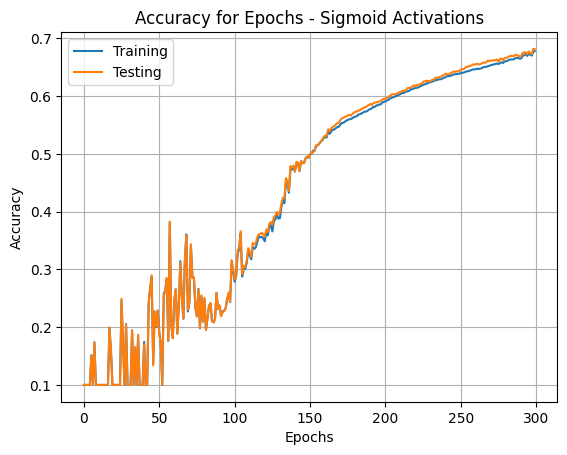

In [ ]:
data = [("Training", MLP_sigmoid.train_logger),("Testing", MLP_sigmoid.test_logger)]
plot_graph("Accuracy for Epochs - Sigmoid Activations", data)

See results of `MLP_leaky_ReLU`

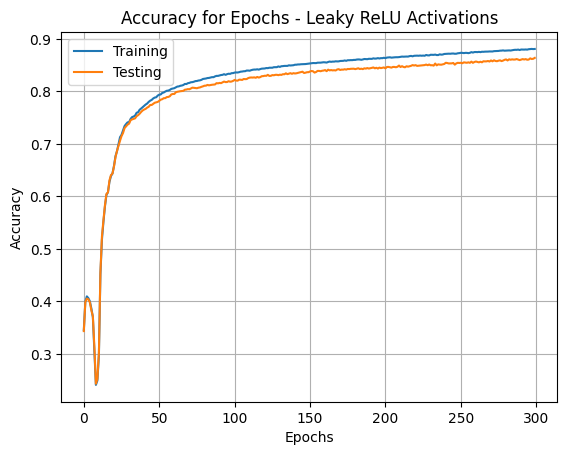

In [ ]:
data = [("Training", MLP_leaky_ReLU.train_logger),("Testing", MLP_leaky_ReLU.test_logger)]
plot_graph("Accuracy for Epochs - Leaky ReLU Activations", data)

## Part 4: Applying L1 and L2 Regularization to the Model
Create an MLP with 2 hidden layers each having 128 units with ReLU activations as above. However, this time, independently add L1 and L2 regularization to the network and train the MLP in this way.

How do these 3 regularizations affect the accuracy? (This proportion can be varied as a tunable hyperparameter that can be explored as part of other project requirements)

In [ ]:
#Regularization Model here
MLP_L1 = MultiLayerPerceptron([784,64,64,10],[Relu_Class, Relu_Class, softmax_Class], weight = "kaiming")
MLP_L2 = MultiLayerPerceptron([784,64,64,10],[Relu_Class, Relu_Class, softmax_Class], weight = "kaiming")

In [ ]:
#Fitting L1 with small reg strength
MLP_L1.fit(fashion_trainset_x, fashion_trainset_y, 300, 256, 0.001, fashion_testset_x, fashion_testset_y, regularization = 1, lambd = 0.0005)

L1 Reg
Epoch 0 train data: 26.98333333333333 %
Epoch 0 test data: 26.97 %
Epoch 1 train data: 29.875 %
Epoch 1 test data: 30.03 %
Epoch 2 train data: 28.316666666666666 %
Epoch 2 test data: 28.410000000000004 %
Epoch 3 train data: 25.898333333333333 %
Epoch 3 test data: 25.96 %
Epoch 4 train data: 25.433333333333337 %
Epoch 4 test data: 25.45 %
Epoch 5 train data: 33.055 %
Epoch 5 test data: 33.2 %
Epoch 6 train data: 28.636666666666667 %
Epoch 6 test data: 28.96 %
Epoch 7 train data: 34.63666666666666 %
Epoch 7 test data: 35.11 %
Epoch 8 train data: 42.61333333333333 %
Epoch 8 test data: 43.3 %
Epoch 9 train data: 49.288333333333334 %
Epoch 9 test data: 49.59 %
Epoch 10 train data: 54.94833333333333 %
Epoch 10 test data: 55.71 %
Epoch 11 train data: 59.255 %
Epoch 11 test data: 59.29 %
Epoch 12 train data: 63.531666666666666 %
Epoch 12 test data: 63.29 %
Epoch 13 train data: 64.625 %
Epoch 13 test data: 64.66 %
Epoch 14 train data: 65.77 %
Epoch 14 test data: 65.4 %
Epoch 15 train dat

In [ ]:
#Fitting the Model's for L2 with big reg strength
MLP_L2.fit(fashion_trainset_x, fashion_trainset_y, 300, 256, 0.001, fashion_testset_x, fashion_testset_y, regularization = 2, lambd = 0.05)

L2 Reg
Epoch 0 train data: 37.955 %
Epoch 0 test data: 38.57 %
Epoch 1 train data: 40.175 %
Epoch 1 test data: 40.660000000000004 %
Epoch 2 train data: 40.20666666666667 %
Epoch 2 test data: 40.42 %
Epoch 3 train data: 39.365 %
Epoch 3 test data: 39.62 %
Epoch 4 train data: 33.335 %
Epoch 4 test data: 33.71 %
Epoch 5 train data: 30.196666666666665 %
Epoch 5 test data: 30.470000000000002 %
Epoch 6 train data: 30.61333333333333 %
Epoch 6 test data: 30.79 %
Epoch 7 train data: 34.50666666666667 %
Epoch 7 test data: 35.05 %
Epoch 8 train data: 39.30833333333334 %
Epoch 8 test data: 39.73 %
Epoch 9 train data: 43.24166666666667 %
Epoch 9 test data: 43.71 %
Epoch 10 train data: 48.24666666666666 %
Epoch 10 test data: 48.53 %
Epoch 11 train data: 53.400000000000006 %
Epoch 11 test data: 53.7 %
Epoch 12 train data: 57.596666666666664 %
Epoch 12 test data: 58.13 %
Epoch 13 train data: 60.34666666666667 %
Epoch 13 test data: 60.540000000000006 %
Epoch 14 train data: 62.26166666666667 %
Epoch 14 

In [ ]:
#Model here using MLP_L1 but regularization strength = 0.01
MLP_L15 = MultiLayerPerceptron([784,64,64,10],[Relu_Class, Relu_Class, softmax_Class], weight = "kaiming")
MLP_L15.fit(fashion_trainset_x, fashion_trainset_y, 300, 256, 0.001, fashion_testset_x, fashion_testset_y, regularization = 1, lambd = 0.01)

L1 Reg
Epoch 0 train data: 43.98166666666667 %
Epoch 0 test data: 44.690000000000005 %
Epoch 1 train data: 44.87833333333333 %
Epoch 1 test data: 45.57 %
Epoch 2 train data: 41.86 %
Epoch 2 test data: 42.13 %
Epoch 3 train data: 30.081666666666667 %
Epoch 3 test data: 30.520000000000003 %
Epoch 4 train data: 27.875 %
Epoch 4 test data: 27.700000000000003 %
Epoch 5 train data: 14.906666666666665 %
Epoch 5 test data: 15.2 %
Epoch 6 train data: 25.888333333333335 %
Epoch 6 test data: 25.759999999999998 %
Epoch 7 train data: 28.488333333333333 %
Epoch 7 test data: 28.57 %
Epoch 8 train data: 15.906666666666666 %
Epoch 8 test data: 16.18 %
Epoch 9 train data: 13.503333333333334 %
Epoch 9 test data: 13.16 %
Epoch 10 train data: 13.15 %
Epoch 10 test data: 12.94 %
Epoch 11 train data: 10.73 %
Epoch 11 test data: 10.7 %
Epoch 12 train data: 9.951666666666666 %
Epoch 12 test data: 9.950000000000001 %
Epoch 13 train data: 10.306666666666667 %
Epoch 13 test data: 10.17 %
Epoch 14 train data: 14.0

See Results using L1 regularization (Big Lambda, Lambda = 0.01)

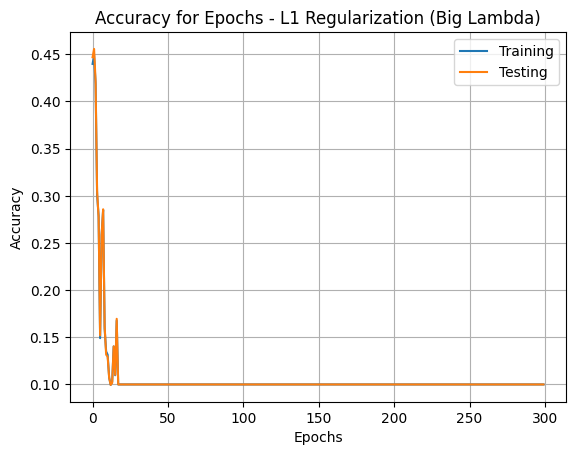

In [ ]:
data = [("Training", MLP_L15.train_logger),("Testing", MLP_L15.test_logger)]
plot_graph("Accuracy for Epochs - L1 Regularization (Big Lambda)", data)

See results using L2 regularization (Lambda = 0.01)

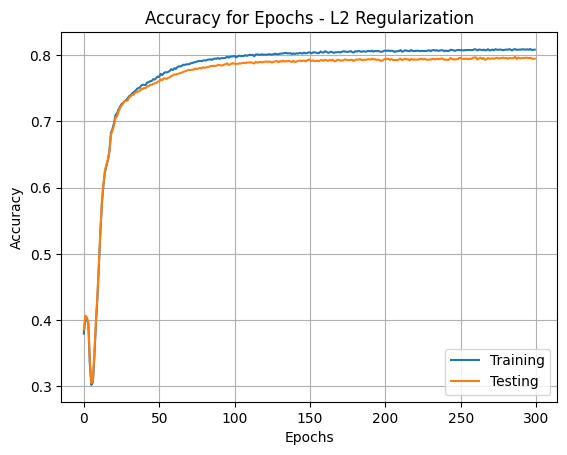

In [ ]:
data = [("Training", MLP_L2.train_logger),("Testing", MLP_L2.test_logger)]
plot_graph("Accuracy for Epochs - L2 Regularization", data)

See results using L1 regularization (Small Lambda, Lambda = 0.0005)

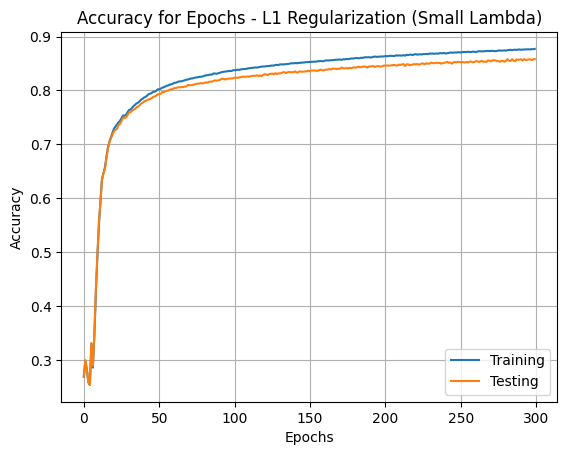

In [ ]:
data = [("Training", MLP_L1.train_logger),("Testing", MLP_L1.test_logger)]
plot_graph("Accuracy for Epochs - L1 Regularization (Small Lambda)", data)

## Part 5: Training MLP with unnormalized images
Create an MLP with 2 hidden layers each having 128 units with ReLU activations as above.

However, this time, train it with unnormalized images. How does this affect the accuracy?

In [ ]:
#Redownloading the mnist dataset without normalizing
transform = transform = transforms.Compose([transforms.ToTensor()])
trainset_unnorm = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset_unnorm = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

trainloader_unnorm = torch.utils.data.DataLoader(trainset_unnorm, batch_size=len(trainset_unnorm), shuffle=False)
testloader_unnorm = torch.utils.data.DataLoader(testset_unnorm, batch_size=len(testset_unnorm), shuffle=False)

for (images, labels) in trainloader_unnorm:
  fashion_trainset_x_unnorm = images.numpy().reshape(len(trainset_unnorm), (images.shape[2]*images.shape[3]), images.shape[1])
  fashion_trainset_y_unnorm = labels.numpy()

for (images, labels) in testloader_unnorm:
  fashion_testset_x_unnorm = images.numpy().reshape(len(testset_unnorm), (images.shape[2]*images.shape[3]), images.shape[1])
  fashion_testset_y_unnorm = labels.numpy()

#Note: Even though the labels are not normalized/unnormalized, we keep these variable names to uphold consistency in the code
#Now we have the dataset as a tensor, need to convert it to a numpy array

In [ ]:
#Defining the Model here and fitting it
MLP_unnorm = MultiLayerPerceptron([784,64,64,10],[Relu_Class, Relu_Class, softmax_Class], weight = "kaiming")
MLP_unnorm.fit(fashion_trainset_x_unnorm, fashion_trainset_y_unnorm, 300, 256, 0.001, fashion_testset_x_unnorm, fashion_testset_y_unnorm, regularization = 0, lambd = 0)

No Reg
Epoch 0 train data: 28.525 %
Epoch 0 test data: 28.349999999999998 %
Epoch 1 train data: 35.09833333333333 %
Epoch 1 test data: 34.47 %
Epoch 2 train data: 34.373333333333335 %
Epoch 2 test data: 34.04 %
Epoch 3 train data: 31.246666666666666 %
Epoch 3 test data: 30.5 %
Epoch 4 train data: 24.638333333333335 %
Epoch 4 test data: 24.02 %
Epoch 5 train data: 21.238333333333333 %
Epoch 5 test data: 20.95 %
Epoch 6 train data: 20.80333333333333 %
Epoch 6 test data: 20.32 %
Epoch 7 train data: 22.566666666666666 %
Epoch 7 test data: 22.16 %
Epoch 8 train data: 23.5 %
Epoch 8 test data: 23.419999999999998 %
Epoch 9 train data: 21.556666666666665 %
Epoch 9 test data: 21.45 %
Epoch 10 train data: 18.415 %
Epoch 10 test data: 18.44 %
Epoch 11 train data: 18.14 %
Epoch 11 test data: 18.21 %
Epoch 12 train data: 21.025 %
Epoch 12 test data: 20.93 %
Epoch 13 train data: 26.093333333333334 %
Epoch 13 test data: 26.200000000000003 %
Epoch 14 train data: 32.684999999999995 %
Epoch 14 test data

See results for MLP with unnormalized images

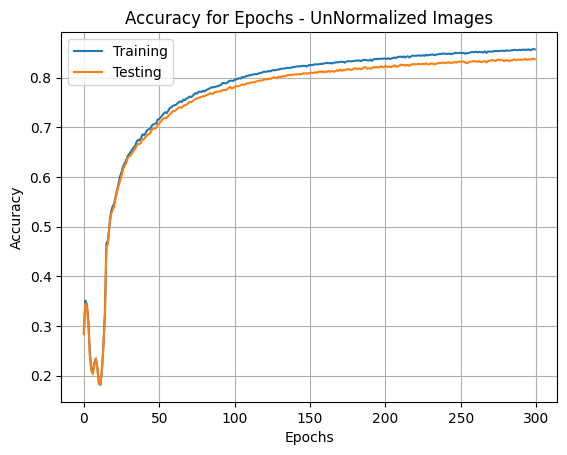

In [ ]:
data = [("Training", MLP_unnorm.train_logger),("Testing", MLP_unnorm.test_logger)]
plot_graph("Accuracy for Epochs - UnNormalized Images", data)

## Part 6: Implementation of a CNN model using PyTorch, Comparison with MLP
Using PyTorch, create a convolutional neural network (CNN) with 2 convolutional and 2 fully connected layers. Although you are free in your choice of the hyperparameters of the convolutional layers, set the number of units in the fully connected layers to be 128. Also, set the activations in all of the layers to be ReLU. Train this CNN on the Fashion MNIST dataset.

Does using a CNN increase/decrease the accuracy compared to using MLPs?
Provide comments on your results.

In [ ]:
#Defining the CovNet Class using the nn.model (For the MNIST DATASET)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)  # Changed input channel to 1
        self.conv2 = nn.Conv2d(32, 64, 3)
        #.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)  # Adjusted size to fit Fashion MNIST image dimensions
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        #x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        #x = self.dropout(x)
        x = self.fc2(x)
        return x


Loading the MNIST dataset, (loaded differently)

In [ ]:
# Image preprocessing modules
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Adjusted normalization for grayscale images
])
# Fashion MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)



In [ ]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=perm_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=perm_batch_size, shuffle=False)


In [ ]:
#Running the Model and Defining some functions

#Utlizing GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNet().to(device)

#Setting the Optimizer/Loss Functions
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0000)

train_list = []
test_list = []

# Training the model
num_epochs = CNN_EPOCHS
for epoch in range(num_epochs):
    running_loss = 0.0

    model.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = outputs.max(1)
        correct = (predicted == labels).sum().item()
        batch_accuracy = 100 * correct / labels.size(0)
        if i % 100 == 0:
            print(f'[{epoch + 1}, {i + 1}] loss: {loss.item():.3f} | accuracy: {batch_accuracy:.2f}%')
        running_loss += loss.item()
    test_acc = compute_accuracy(model, test_loader, device)
    train_list.append(batch_accuracy)
    test_list.append(test_acc)
    print(f"Test Accuracy at epoch {epoch} is: {test_acc:.2f}%")
print('Finished Training')

# Test the model
model.eval()
accuracy = compute_accuracy(model, test_loader, device)
print(f"Accuracy of the model on the test dataset: {accuracy:.2f}%")


[1, 1] loss: 2.312 | accuracy: 0.78%
[1, 101] loss: 0.591 | accuracy: 78.12%
[1, 201] loss: 0.579 | accuracy: 79.30%
Test Accuracy at epoch 0 is: 80.07%
[2, 1] loss: 0.528 | accuracy: 81.25%
[2, 101] loss: 0.389 | accuracy: 86.33%
[2, 201] loss: 0.449 | accuracy: 85.94%
Test Accuracy at epoch 1 is: 83.89%
[3, 1] loss: 0.474 | accuracy: 82.03%
[3, 101] loss: 0.369 | accuracy: 85.55%
[3, 201] loss: 0.346 | accuracy: 86.72%
Test Accuracy at epoch 2 is: 84.76%
[4, 1] loss: 0.471 | accuracy: 83.59%
[4, 101] loss: 0.329 | accuracy: 89.45%
[4, 201] loss: 0.413 | accuracy: 83.20%
Test Accuracy at epoch 3 is: 85.90%
[5, 1] loss: 0.426 | accuracy: 85.55%
[5, 101] loss: 0.296 | accuracy: 89.06%
[5, 201] loss: 0.401 | accuracy: 84.77%
Test Accuracy at epoch 4 is: 86.33%
[6, 1] loss: 0.330 | accuracy: 87.89%
[6, 101] loss: 0.203 | accuracy: 92.58%
[6, 201] loss: 0.366 | accuracy: 86.33%
Test Accuracy at epoch 5 is: 87.05%
[7, 1] loss: 0.307 | accuracy: 90.23%
[7, 101] loss: 0.226 | accuracy: 90.23%

See the results for the CNN on MNIST

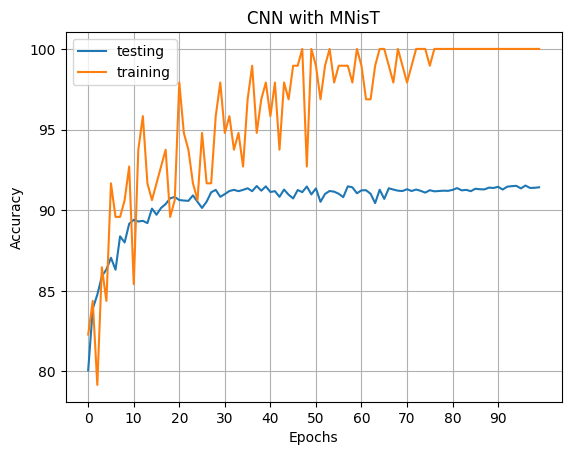

In [ ]:
plot_graph_CNN("CNN with MNisT", [("testing", test_list),("training", train_list)])

## Part 7: Training MLP on CIFAR, Comparing with CNN
Now using the CIFAR-10 dataset, train an MLP using your implementation (with whatever layer dimensions you like), and a CNN with the same architecture restrictions as in (6).

How does using a CNN increase/decrease
the accuracy compared to using MLPs on this dataset?

Defining the CNN Model for CIFAR Dataset

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.dropout = nn.Dropout(0.25)  # Adjusted dropout rate
        self.fc1 = nn.Linear(64 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)  # Applying dropout after pooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Applying dropout before final layer
        x = self.fc2(x)
        return x

Data loading

In [ ]:
# Image preprocessing modules         ###############     INCLUDES DATA AUGMENTATION FOR REGULARIZATION! ####################
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=perm_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=perm_batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


Setting Variables and Training the Model

In [ ]:
#GPU Optimization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
# Added L2 regularization using weight_decay parameter
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0000)
plot_list = []

# Training the model
num_epochs = CNN_EPOCHS
for epoch in range(num_epochs):
    running_loss = 0.0

    model.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = outputs.max(1)
        correct = (predicted == labels).sum().item()
        batch_accuracy = 100 * correct / labels.size(0)
        #model.eval()
        #testing_accuracy = compute_accuracy(model, test_loader, device)
        if i % 100 == 0:  # Print after every 100 minibatches
            print(f'[{epoch + 1}, {i + 1}] loss: {loss.item():.3f} | accuracy: {batch_accuracy:.2f}%')
            #print(testing_accuracy)
            plot_list.append([epoch, batch_accuracy]) ##testing_accuracy])
        running_loss += loss.item()

    test_acc = compute_accuracy(model, test_loader, device)
    print(f"Test Accuracy at epoch {epoch} is: {test_acc:.2f}%")
print('Finished Training')

# Test the model
model.eval()  # Change model to 'eval' mode (batchnorm uses moving mean/variance).
accuracy = compute_accuracy(model, test_loader, device)
print(f"Accuracy of the model on the test dataset: {accuracy:.2f}%")

[1, 1] loss: 2.307 | accuracy: 9.38%
[1, 101] loss: 2.025 | accuracy: 25.78%
Test Accuracy at epoch 0 is: 32.67%
[2, 1] loss: 1.956 | accuracy: 25.39%
[2, 101] loss: 1.724 | accuracy: 38.28%
Test Accuracy at epoch 1 is: 41.83%
[3, 1] loss: 1.597 | accuracy: 41.02%
[3, 101] loss: 1.563 | accuracy: 44.53%
Test Accuracy at epoch 2 is: 45.17%
[4, 1] loss: 1.535 | accuracy: 41.80%
[4, 101] loss: 1.477 | accuracy: 50.00%
Test Accuracy at epoch 3 is: 47.62%
[5, 1] loss: 1.488 | accuracy: 47.66%
[5, 101] loss: 1.490 | accuracy: 46.09%
Test Accuracy at epoch 4 is: 49.69%
[6, 1] loss: 1.528 | accuracy: 44.53%
[6, 101] loss: 1.467 | accuracy: 49.22%
Test Accuracy at epoch 5 is: 52.97%
[7, 1] loss: 1.353 | accuracy: 50.39%
[7, 101] loss: 1.410 | accuracy: 50.78%
Test Accuracy at epoch 6 is: 54.19%
[8, 1] loss: 1.302 | accuracy: 51.56%
[8, 101] loss: 1.261 | accuracy: 54.69%
Test Accuracy at epoch 7 is: 57.23%
[9, 1] loss: 1.240 | accuracy: 54.69%
[9, 101] loss: 1.240 | accuracy: 57.42%
Test Accura

See the results for using a CNN with CIFAR

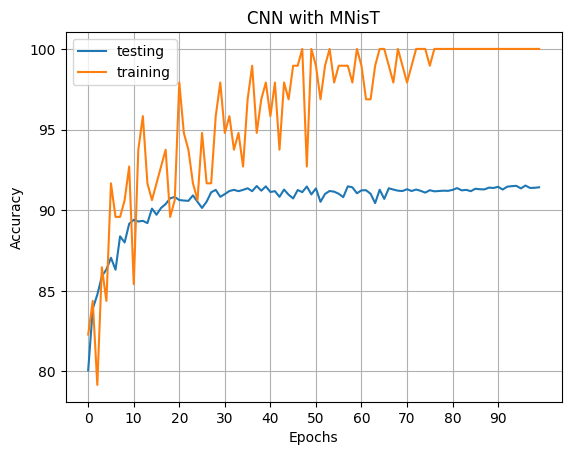

In [ ]:
plot_graph_CNN("CNN with MNisT", [("testing", test_list),("training", train_list)])

Loading the DATA for MLP and Defining the model/fit

In [ ]:
transformC = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainsetC = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transformC)
testsetC = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transformC)

trainloaderC = torch.utils.data.DataLoader(trainsetC, batch_size=len(trainsetC), shuffle=False)
testloaderC = torch.utils.data.DataLoader(testsetC, batch_size=len(testsetC), shuffle=False)

for (images, labels) in trainloaderC:
  Cifar_trainset_x = images.numpy().reshape(len(trainsetC), (images.shape[2]*images.shape[3]), images.shape[1])
  Cifar_trainset_y = labels.numpy()

for (images, labels) in testloaderC:
  Cifar_testset_x = images.numpy().reshape(len(testsetC), (images.shape[2]*images.shape[3]), images.shape[1])
  Cifar_testset_y = labels.numpy()

MLP_C = MultiLayerPerceptron([3072,128,128,10],[Relu_Class, Relu_Class, softmax_Class], weight = "kaiming")
MLP_C.fit(Cifar_trainset_x, Cifar_trainset_y, 300, 256, 0.001, Cifar_testset_x, Cifar_testset_y, regularization = 2, lambd = 0.01)

100%|██████████| 170498071/170498071 [00:04<00:00, 38627653.52it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
L2 Reg
Epoch 0 train data: 17.648 %
Epoch 0 test data: 17.84 %
Epoch 1 train data: 18.514 %
Epoch 1 test data: 18.4 %
Epoch 2 train data: 19.108 %
Epoch 2 test data: 19.56 %
Epoch 3 train data: 19.556 %
Epoch 3 test data: 20.11 %
Epoch 4 train data: 19.808 %
Epoch 4 test data: 20.39 %
Epoch 5 train data: 19.816 %
Epoch 5 test data: 20.49 %
Epoch 6 train data: 19.738 %
Epoch 6 test data: 20.419999999999998 %
Epoch 7 train data: 19.542 %
Epoch 7 test data: 20.25 %
Epoch 8 train data: 19.274 %
Epoch 8 test data: 19.85 %
Epoch 9 train data: 18.948 %
Epoch 9 test data: 19.43 %
Epoch 10 train data: 18.514 %
Epoch 10 test data: 18.87 %
Epoch 11 train data: 18.01 %
Epoch 11 test data: 18.3 %
Epoch 12 train data: 17.564 %
Epoch 12 test data: 17.7 %
Epoch 13 train data: 17.096 %
Epoch 13 test data: 17.39 %
Epoch 14 train data: 16.752 %
Epoch 14 test data: 16.939999999999998 %
Epoch 15 train data: 16.348 %
Ep

Plotting the Graphs for MLP trained on CIFAR

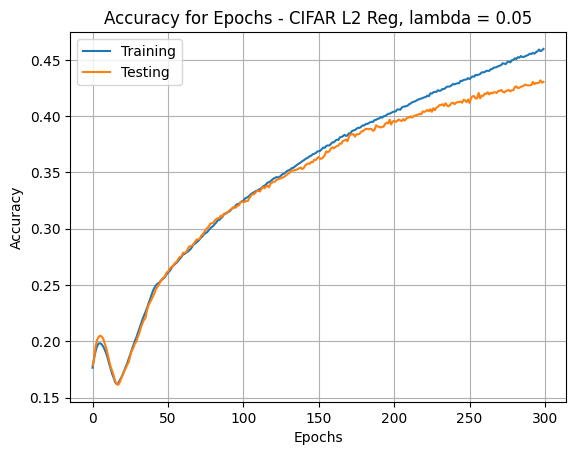

In [ ]:
data = [("Training", MLP_C.train_logger),("Testing", MLP_C.test_logger)]
plot_graph("Accuracy for Epochs - CIFAR L2 Reg, lambda = 0.05", data)

## Part 8: Analyzing different Momentums
In your CNN implemented with PyTorch, investigate the effects of optimizer on performance on the CIFAR-10 dataset. Using an SGD optimizer, set the momentum factor to zero, and then try to increase it.

How does changing this value impact the training and performance of the network in terms of convergence speed, final accuracy, and stability? How do these compare if you instead use an Adam optimizer?

In [ ]:
#########3.8


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

def compute_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy


class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.dropout = nn.Dropout(0.25)  # Adjusted dropout rate
        self.fc1 = nn.Linear(64 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)  # Applying dropout after pooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Applying dropout before final layer
        x = self.fc2(x)
        return x

# Image preprocessing modules
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
# Added L2 regularization using weight_decay parameter

############ INSERT FROM HERE DOWN INTO SUBMISSIONS
final_training = []
final_testing = []
momentums = [0, .25, .75, .9,.99]
#momentums = [0]
for momentum in momentums:
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=momentum, weight_decay=0.0000)

    train_list = []
    test_list = []
    # Training the model
    num_epochs = 100
    for epoch in range(num_epochs):
        running_loss = 0.0

        model.train()
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = outputs.max(1)
            correct = (predicted == labels).sum().item()
            batch_accuracy = 100 * correct / labels.size(0)
            #model.eval()
            #testing_accuracy = compute_accuracy(model, test_loader, device)
            if i % 100 == 0:  # Print after every 100 minibatches
                print(f'[{epoch + 1}, {i + 1}] loss: {loss.item():.3f} | accuracy: {batch_accuracy:.2f}%')
            running_loss += loss.item()
        test_acc = compute_accuracy(model, test_loader, device)
        train_list.append(batch_accuracy)
        test_list.append(test_acc)
        print(f"Test Accuracy at epoch {epoch+1} is: {test_acc:.2f}%")
    print('Finished Training')

    # Test the model
    model.eval()  # Change model to 'eval' mode (batchnorm uses moving mean/variance).
    accuracy = compute_accuracy(model, test_loader, device)
    print(f"Accuracy of the model on the test dataset: {accuracy:.2f}%")
    final_testing.append(test_list)
    final_training.append(train_list)



100%|██████████| 170498071/170498071 [00:10<00:00, 15879595.64it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
[1, 1] loss: 2.299 | accuracy: 11.33%
[1, 101] loss: 2.267 | accuracy: 17.58%
Test Accuracy at epoch 0 is: 20.26%
[2, 1] loss: 2.241 | accuracy: 19.92%
[2, 101] loss: 2.183 | accuracy: 24.22%
Test Accuracy at epoch 1 is: 24.82%
[3, 1] loss: 2.119 | accuracy: 22.66%
[3, 101] loss: 2.096 | accuracy: 24.22%
Test Accuracy at epoch 2 is: 27.44%
[4, 1] loss: 2.062 | accuracy: 23.05%
[4, 101] loss: 1.999 | accuracy: 21.88%
Test Accuracy at epoch 3 is: 29.16%
[5, 1] loss: 1.942 | accuracy: 32.42%
[5, 101] loss: 1.980 | accuracy: 23.83%
Test Accuracy at epoch 4 is: 31.80%
[6, 1] loss: 1.896 | accuracy: 29.69%
[6, 101] loss: 1.853 | accuracy: 35.55%
Test Accuracy at epoch 5 is: 33.12%
[7, 1] loss: 1.870 | accuracy: 33.20%
[7, 101] loss: 1.868 | accuracy: 32.42%
Test Accuracy at epoch 6 is: 36.45%
[8, 1] loss: 1.807 | accuracy: 37.50%
[8, 101] loss: 1.800 | accuracy: 37.50%
Test Accuracy at epoch 7 is: 37.54%

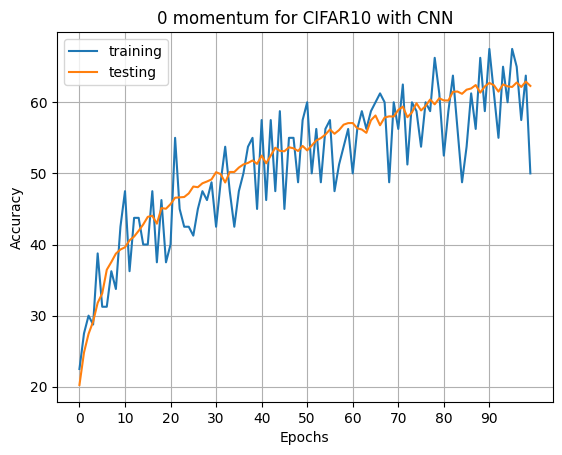

In [ ]:

#no momentum test
plot_graph("0 momentum for CIFAR10 with CNN", [("training", final_training[0]),("testing", final_testing[0])])

In [ ]:
#every momentum test
plot_graph("Different Momentums for Training, CIFAR10 with CNN", [("0.0", final_training[0]),("0.25", final_training[1]), ("0.75", final_training[2]), ("0.9", final_training[3]), ("0.99", final_training[4])])
plot_graph("Different Momentums for Testing, CIFAE10 with CNN", [("0.0", final_testing[0]),("0.25", final_testing[1]), ("0.75", final_testing[2]), ("0.9", final_testing[3]), ("0.99", final_testing[4])])

In [ ]:
#adam test
final_training = []
final_testing = []

optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0000)

train_list = []
test_list = []
# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    running_loss = 0.0

    model.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = outputs.max(1)
        correct = (predicted == labels).sum().item()
        batch_accuracy = 100 * correct / labels.size(0)
        #model.eval()
        #testing_accuracy = compute_accuracy(model, test_loader, device)
        if i % 100 == 0:  # Print after every 100 minibatches
            print(f'[{epoch + 1}, {i + 1}] loss: {loss.item():.3f} | accuracy: {batch_accuracy:.2f}%')
        running_loss += loss.item()
    test_acc = compute_accuracy(model, test_loader, device)
    train_list.append(batch_accuracy)
    test_list.append(test_acc)
    print(f"Test Accuracy at epoch {epoch+1} is: {test_acc:.2f}%")
print('Finished Training')

# Test the model
model.eval()  # Change model to 'eval' mode (batchnorm uses moving mean/variance).
accuracy = compute_accuracy(model, test_loader, device)
print(f"Accuracy of the model on the test dataset: {accuracy:.2f}%")
final_testing.append(test_list)
final_training.append(train_list)

[1, 1] loss: 1.132 | accuracy: 57.42%
[1, 101] loss: 1.865 | accuracy: 30.86%
Test Accuracy at epoch 1 is: 33.88%
[2, 1] loss: 1.780 | accuracy: 30.08%
[2, 101] loss: 1.714 | accuracy: 35.94%
Test Accuracy at epoch 2 is: 37.97%
[3, 1] loss: 1.667 | accuracy: 38.28%
[3, 101] loss: 1.598 | accuracy: 39.84%
Test Accuracy at epoch 3 is: 40.05%
[4, 1] loss: 1.615 | accuracy: 41.80%
[4, 101] loss: 1.650 | accuracy: 39.06%
Test Accuracy at epoch 4 is: 42.49%
[5, 1] loss: 1.579 | accuracy: 38.67%
[5, 101] loss: 1.528 | accuracy: 44.14%
Test Accuracy at epoch 5 is: 43.83%
[6, 1] loss: 1.602 | accuracy: 41.80%
[6, 101] loss: 1.551 | accuracy: 41.41%
Test Accuracy at epoch 6 is: 49.84%
[7, 1] loss: 1.476 | accuracy: 47.66%
[7, 101] loss: 1.539 | accuracy: 44.53%
Test Accuracy at epoch 7 is: 48.60%
[8, 1] loss: 1.562 | accuracy: 45.70%
[8, 101] loss: 1.430 | accuracy: 47.27%
Test Accuracy at epoch 8 is: 50.16%
[9, 1] loss: 1.470 | accuracy: 46.09%
[9, 101] loss: 1.471 | accuracy: 49.22%
Test Accur

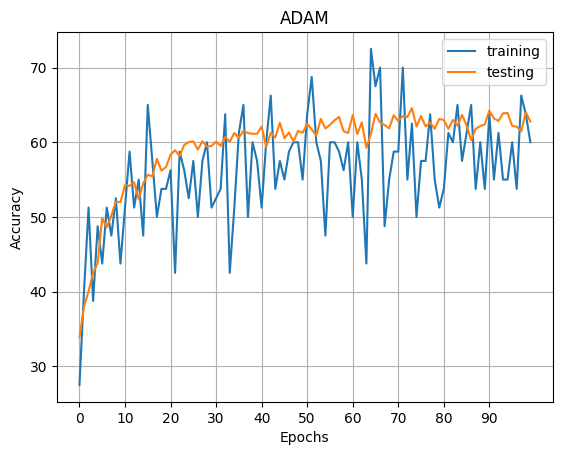

In [ ]:
#adam plot
plot_graph("ADAM", [("training", final_training[0]),("testing", final_testing[0])])


## Part 9: Originality and Other Experiments
Description for this part can be found in the 4.9 section of the overleaf documentation

In [ ]:
#########3.9

import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

def get_fc_layers(input_size, config):
    layers = [nn.Flatten()]  # Start with a flattening layer
    num_features = input_size
    for i in range(len(config)):
        layers.append(nn.Linear(num_features, config[i]))
        layers.append(nn.ReLU())
        if i != len(config) - 1:
            layers.append(nn.Dropout(0.25))
        num_features = config[i]
    layers.append(nn.Linear(config[-1], 10))
    return nn.Sequential(*layers)

def compute_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# CIFAR-10 data loading and preprocessing
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

configurations = [[512], [512, 256], [512, 256, 128]]

results = {}

for config in configurations:
    squeezenet = models.squeezenet1_1(pretrained=True).to(device)
    for param in squeezenet.parameters():
        param.requires_grad = False

    # The size of the tensor right before the classifier in SqueezeNet is 512x13x13.
    # Therefore, our custom classifier should start by handling a tensor of this size.
    squeezenet.classifier = get_fc_layers(512*13*13, config).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(squeezenet.classifier.parameters(), lr=0.01)

    train_accuracies = []
    val_accuracies = []

    # Training loop (assuming 10 epochs for the sake of this example)
    for epoch in range(10):  # Change the number of epochs if needed
        running_loss = 0.0
        squeezenet.train()
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = squeezenet(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_accuracy = compute_accuracy(squeezenet, trainloader, device)
        val_accuracy = compute_accuracy(squeezenet, testloader, device)

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Config {config} - Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}, Train Accuracy: {train_accuracy}%, Validation Accuracy: {val_accuracy}%")

    results[str(config)] = {
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies
    }

# Printing final results
for config, accs in results.items():
    print(f"Configuration {config}:")
    print(f"  Train Accuracies: {accs['train_accuracies']}")
    print(f"  Validation Accuracies: {accs['val_accuracies']}")



Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 43.1MB/s]


Config [512] - Epoch 1, Loss: 6.32140321199206, Train Accuracy: 10.21%, Validation Accuracy: 10.18%
Config [512] - Epoch 2, Loss: 2.728775630756898, Train Accuracy: 10.096%, Validation Accuracy: 10.09%
Config [512] - Epoch 3, Loss: 3.5914876256626687, Train Accuracy: 10.074%, Validation Accuracy: 10.03%
Config [512] - Epoch 4, Loss: 2.3365404970433876, Train Accuracy: 10.07%, Validation Accuracy: 10.02%
Config [512] - Epoch 5, Loss: 2.3019256449935535, Train Accuracy: 10.066%, Validation Accuracy: 10.02%
Config [512] - Epoch 6, Loss: 2.302105535701232, Train Accuracy: 10.078%, Validation Accuracy: 10.04%
Config [512] - Epoch 7, Loss: 2.301975900823309, Train Accuracy: 10.072%, Validation Accuracy: 10.02%
Config [512] - Epoch 8, Loss: 2.302286632382862, Train Accuracy: 10.078%, Validation Accuracy: 10.04%
Config [512] - Epoch 9, Loss: 2.30187308216278, Train Accuracy: 10.072%, Validation Accuracy: 10.02%
Config [512] - Epoch 10, Loss: 2.3019449347802943, Train Accuracy: 10.08%, Validati

In [ ]:
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

def get_fc_layers(num_features, config):
    layers = []
    for i in range(len(config)):
        layers.append(nn.Linear(num_features, config[i]))
        layers.append(nn.ReLU())
        if i != len(config) - 1:
            layers.append(nn.Dropout(0.25))
        num_features = config[i]
    layers.append(nn.Linear(config[-1], 10))
    return nn.Sequential(*layers)

def compute_accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

configurations = [[512, 256], [512, 256, 128]]

results = {}

for config in configurations:
    resnet = models.resnet18(pretrained=True).to(device)
    for param in resnet.parameters():
        param.requires_grad = False

    resnet.fc = get_fc_layers(resnet.fc.in_features, config).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)

    train_accuracies = []
    val_accuracies = []

    for epoch in range(10):
        running_loss = 0.0
        resnet.train()
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = resnet(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_accuracy = compute_accuracy(resnet, trainloader, device)
        val_accuracy = compute_accuracy(resnet, testloader, device)

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Config {config} - Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}, Train Accuracy: {train_accuracy}%, Validation Accuracy: {val_accuracy}%")

    results[str(config)] = {
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies
    }

for config, accs in results.items():
    print(f"Configuration {config}:")
    print(f"  Train Accuracies: {accs['train_accuracies']}")
    print(f"  Validation Accuracies: {accs['val_accuracies']}")